<a href="https://colab.research.google.com/github/Vishal1711/AuE893-Deep-Learning-Application-in-Engineering/blob/main/AuE8930_Mini_Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project 5

Welcome to the last Mini Project! In this assignment, you will implement autoencoders (AEs) and generative adversarial networks (GANs) based on the relevant concepts learned in the class.

---
**Requirements**: 
- Your code should follow [PEP 8](https://www.python.org/dev/peps/pep-0008/) with necessary comments.

## Task 1: Autoencoders vs. Principal Components Analysis
Principal components analysis (PCA) is a common used method for dimensionality reduction. It's an unsupervised technique that reduces the dimensionality of the data by **orthogonally transforming** the data into a set of principal components. The first principal component explains the most amount of the variation in the data in a single component, the second component explains the second most amount of the variation, etc. By choosing the top principal components that explain say 80-90% of the variation, the other components can be dropped since they do not significantly benefit the model.

Autoencoder is another unsupervised technique can be used for dimensionality reduction in which we leverage neural networks for the task of representation learning. Specifically, a **bottleneck** will be imposed in the network which forces a compressed knowledge representation of the original input.

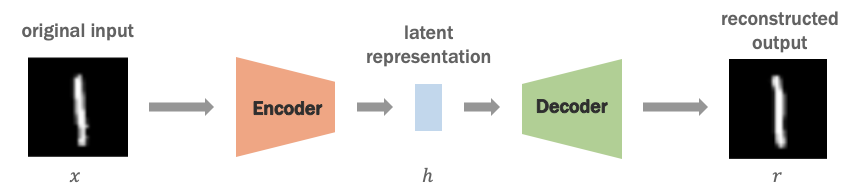


**Tasks**

In this task, you will build two models for dimensionality reduction based on PCA and Autoencoder, respectively. You will use the developed models on the handwritten digits and compare the performance. **The reduced dimension should be two so that the visualization is convenient.**

1. Load [MNIST](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data) dataset and prepross the dataset.
2. Design a PCA model for dimensionality reduction. Please check [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for more information.
3. Implement a Autoencoder based on TensorFlow 2.x.
4. Compare the reconstruction losses (MSE) of PCA and Autoencoder on the test data.
5. Visualize the reduced results of PCA and Autoencoder.
6. Analysis the pros and cons of each model.

In [ ]:
# TODO: write your code here

import numpy as np
import pandas as pd
from keras import backend as K
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import time
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
from IPython import display 
import seaborn as sns

In [ ]:
# import os
# for dirname, _, filenames in os.walk('/content'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


PCA reconstruction error with 2 PCs: 0.056


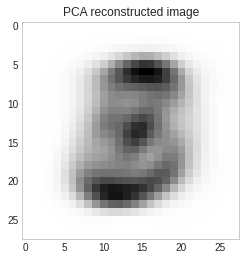

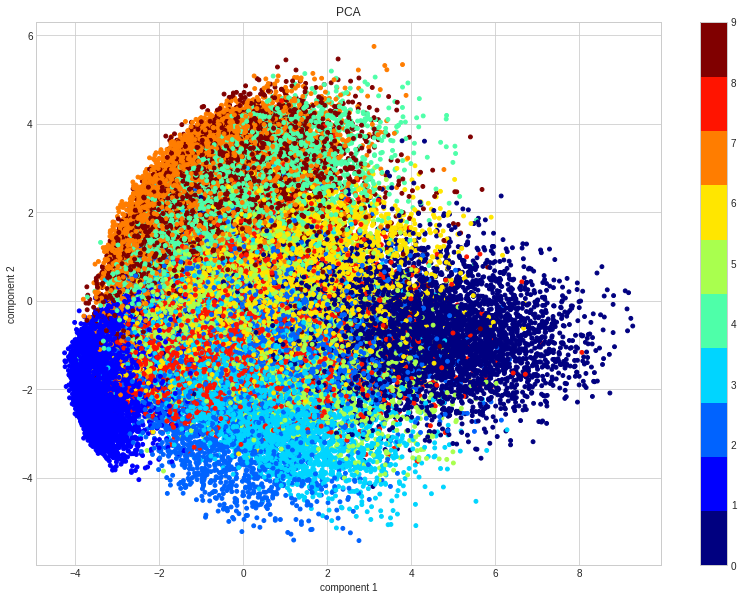

<Figure size 432x288 with 0 Axes>

In [ ]:
# Load MNIST dataset and prepross the dataset.

np.random.seed(0)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32) /255.0
x_train = x_train.reshape(x_train.shape[0],784)

#Design a PCA model for dimensionality reduction

# The reduced dimension should be two
pca = PCA(n_components=2)

X_transformed = pca.fit_transform(x_train)
x_tranformed = X_transformed[0]
red_inverted = pca.inverse_transform(x_tranformed)
red_inverted = red_inverted.reshape(28,28)
plt.grid(False)
plt.title('PCA reconstructed image')
plt.imshow(red_inverted)

mu = x_train.mean(axis=0)
U,s,V = np.linalg.svd(x_train - mu, full_matrices=False)
Zpca = np.dot(x_train - mu, V.transpose())

Rpca = np.dot(Zpca[:,:2], V[:2,:]) + mu    # reconstruction
err = np.sum((x_train-Rpca)**2)/Rpca.shape[0]/Rpca.shape[1]
print('PCA reconstruction error with 2 PCs: ' + str(round(err,3)));

X_transformed.shape
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (14,10))
plt.title('PCA')
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], s = 15,
            cmap = c_map , c = y_train)
plt.colorbar()
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()
plt.savefig("mnist_pca.png")

1875/1875 [==============================] - 137s 73ms/step - loss: 0.0431 - val_loss: 0.0429
Epoch 6/10
1875/1875 [==============================] - 109s 58ms/step - loss: 0.0426 - val_loss: 0.0430
Epoch 7/10
1875/1875 [==============================] - 109s 58ms/step - loss: 0.0423 - val_loss: 0.0423
Epoch 8/10
1875/1875 [==============================] - 109s 58ms/step - loss: 0.0420 - val_loss: 0.0424
Epoch 9/10
1875/1875 [==============================] - 109s 58ms/step - loss: 0.0418 - val_loss: 0.0420
Epoch 10/10
1875/1875 [==============================] - 109s 58ms/step - loss: 0.0416 - val_loss: 0.0421


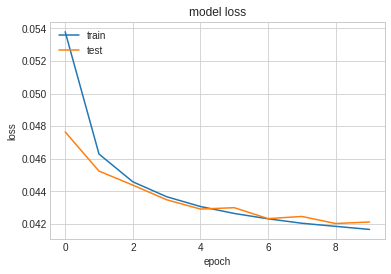

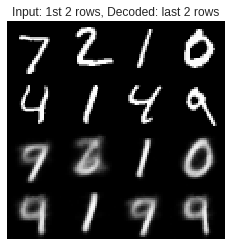

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 2

# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model

# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

shape = K.int_shape(x)

# generate latent vector
x = Flatten()(x)

latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='encoder.png',
           show_shapes=True)

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)

# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()
plot_model(autoencoder,
           to_file='autoencoder.png',
           show_shapes=True)

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# train the autoencoder
history = autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=10,
                batch_size=batch_size)

# Plot the losses

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test)

# display the 1st 8 test input and decoded images
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()


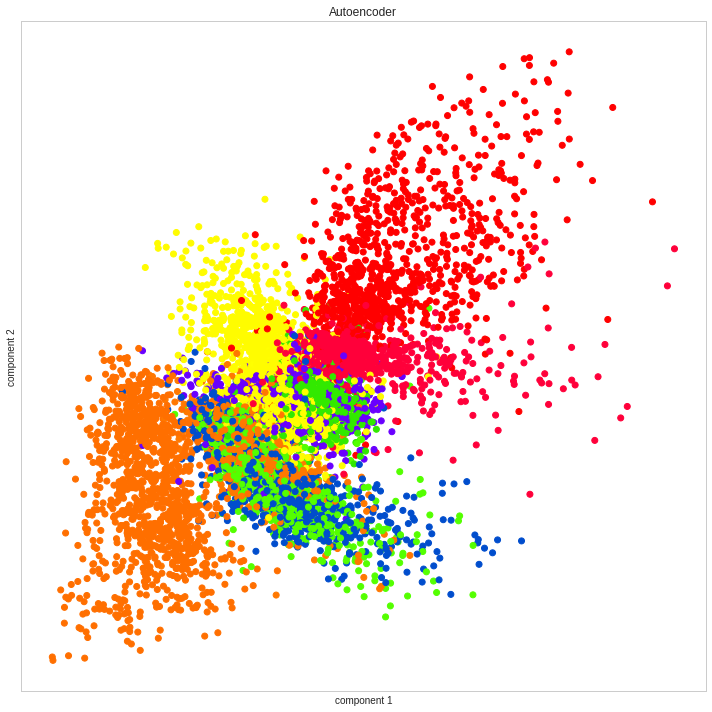

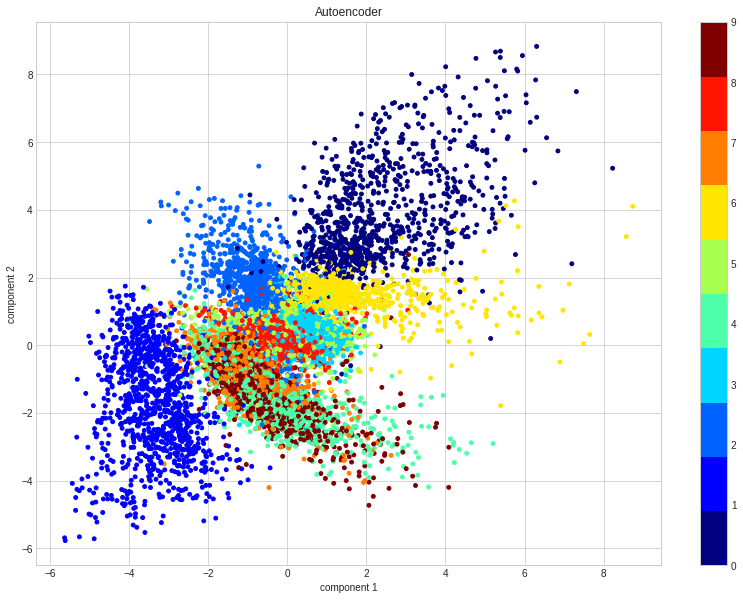

In [ ]:
# Reduced results of encoder 

encoded_imgs = encoder.predict(x_test)
X = encoded_imgs[:,0]
Y = encoded_imgs[:,1]

fig, plot = plt.subplots()
fig.set_size_inches(10, 10)
plt.prism()
plt.scatter(X, Y, c=y_test)
plot.set_xticks(())
plot.set_yticks(())
plt.title('Autoencoder')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.tight_layout()
plt.savefig("mnist_encoder.png")

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (14,10))
plt.title('Autoencoder')
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(X, Y, s = 15,
            cmap = c_map , c = y_test)
plt.colorbar()
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()
plt.grid(False)

conde (2,)
reco (28, 28, 1)


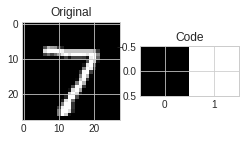

conde (2,)
reco (28, 28, 1)


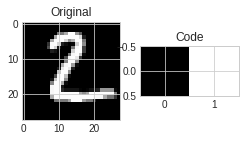

conde (2,)
reco (28, 28, 1)


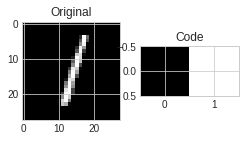

conde (2,)
reco (28, 28, 1)


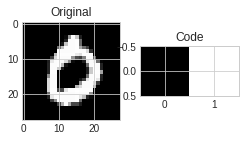

conde (2,)
reco (28, 28, 1)


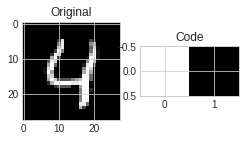

In [ ]:
def visualize(img,encoder,decoder):

    # img[None] will have shape is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img, cmap='gray')

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]), cmap='gray')
    plt.show()

(x_train, y_train), (x_test, y_test) = mnist.load_data()

for i in range(5):
  img = x_test[i]
  visualize(img,encoder,decoder)

Analysis the pros and cons of each model.

1. Reconsruction error of PCA model is 0.056 and loss of autoencoder after 25 iterations is .

PCA Model:

Pros:
1. As far as computation concerned, PCA model is faster than autoencoder.
2. No problem of overfitting.
3. Simple model comapred to autoencoder.

Cons
1. Incapable of learning non-linear feature representations

Autoencoder:

Pros 
1. Able to learn non-linear feature representations

Cons:

1. Computationally expensive to train
2. Autoencoders are more prone to get the condition of overfitting of data than PCA, this is because with autoencoder uses backpropagation, that may learn the features to the extent that it works against the idea of the model.
3. More complex

## Task 2: Generative Adversarial Networks
A generative adversarial network (GAN) is a class of machine learning frameworks designed by Ian Goodfellow and his colleagues in 2014. Two neural networks contest with each other in a game (in the form of a zero-sum game, where one agent's gain is another agent's loss). In this task, you need to create a GAN to generate specific class of figures for given condition (class). For example, give a label "3" (which represents Dress), you will use your network to generate a figure of Dress.

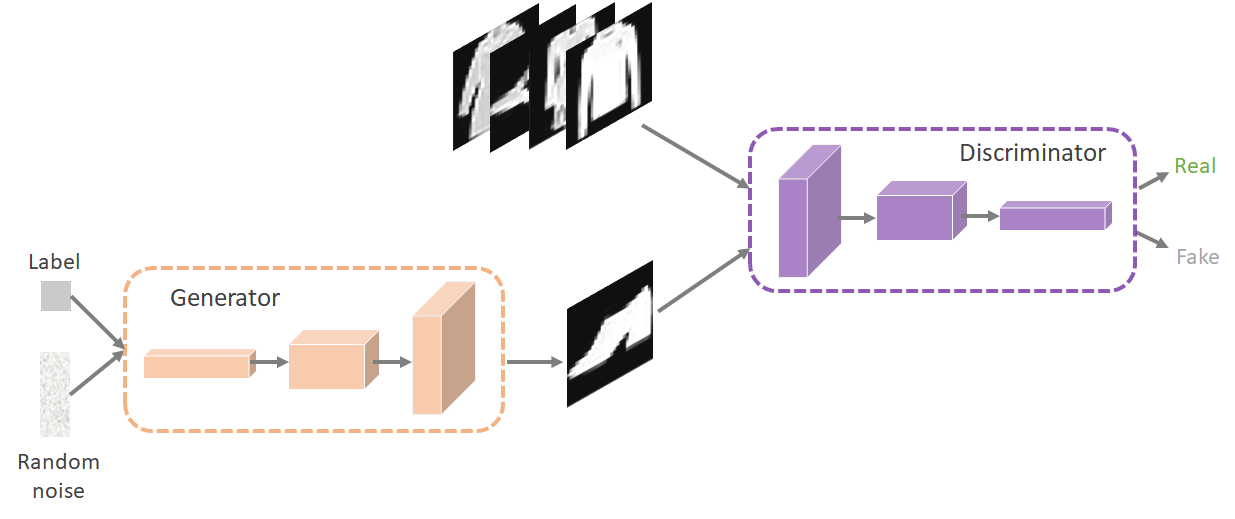



**Dataset**

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

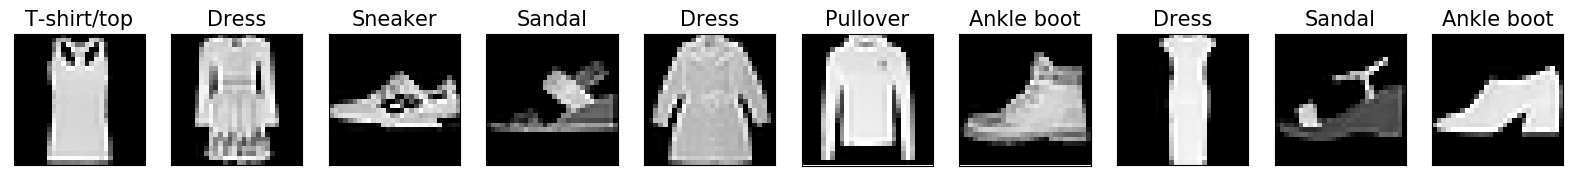

**Tasks**

1. Download the Fashion-Mnist dataset from Canvas and look into the data.
    - The Fashion-Mnist dataset has 60000 training data. Each image is a 28x28 grayscale image, associated with a label from 10 classes. 
2. Load and prepross the dataset.
3. Build a GAN model based on TensorFlow 2.x and plot out the model.
4. Train your model and visualize the training history including the loss of Generator and Discriminator.
5. Plot the intermidiate results through the training procedure. eg.: After each 20 epochs in training plot a grid of generated results. (check this [resource](https://www.tensorflow.org/tutorials/generative/dcgan) to figure out how to save the model and generate the intermediate results during the training)
6. Display final generated results for each of ten classes and discuss your results.

In [ ]:
# TODO: write your code here

import pandas as pd
import csv
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
# import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.8.0


In [ ]:
# Load and prepross the dataset

train_data = pd.read_csv('/content/fashion-mnist_train.csv')
train_data.head()
x_train = train_data.drop('label',axis=1)
x_train.head()
x_train=x_train.values
y_train = pd.read_csv('/content/fashion-mnist_train.csv', usecols= ['label'])
x_train=x_train.reshape(-1,28,28,1)

test_data = pd.read_csv('/content/fashion-mnist_test.csv')
test_data.head()
x_test = test_data.drop('label',axis=1)
x_test.head()
x_test = x_test.values
y_test = pd.read_csv('/content/fashion-mnist_test.csv', usecols= ['label'])
x_test=x_test.reshape(-1,28,28,1)

fig,axe=plt.subplots(2,2)
idx = 0
for i in range(2):
    for j in range(2):
        axe[i,j].imshow(x_train[idx].reshape(28,28),cmap='gray')
        idx+=1

x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32) /255.0

def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

FileNotFoundError: ignored

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

num_features = 100
generator = keras.models.Sequential([
    keras.layers.Dense(7*7*128, input_shape = [num_features]),
    keras.layers.Reshape([7,7,128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64,(5,5),(2,2), padding = 'same',activation = 'selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1,(5,5),(2,2), padding = 'same',activation = 'tanh'),   
])

noise = tf.random.normal(shape=[1,num_features])
generated_image = generator(noise, training=False)
# plt.plot(generated_image,1)
# plt.show()

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5),(2,2), padding='same', input_shape=[28,28,1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

decision = discriminator(generated_image)
print(decision)

In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss = 'binary_crossentropy', optimizer='rmsprop')

seed = tf.random.normal(shape=[batch_size,100])

def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epochs {}/{}".format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images,X_batch], axis=0)
            y1= tf.constant([[0.]]*batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real,y1)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable =False
            gan.train_on_batch(noise, y2)
        display.clear_output(wait = True)
        generate_and_save_images(generator, epoch + 1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs,seed) 


def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
x_train_dcgan = x_train.reshape(-1, 28,28,1)*2. -1

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

%time

train_dcgan(gan, dataset, batch_size, num_features, epochs=10)

noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
plot_utils.show(generated_images,8)

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)